## Table of Contents
***
* Load Music Data
* Get Music Template
* Simple HMM
* HMM variant 1: Two-layered HMM
* HMM variant 2: AR+Layered HMM
* Music Evaluation bach/dmm/lstm

In [1]:
import numpy as np
import pandas as pd
import csv
from numpy import linspace,exp
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import seaborn as sns

import scipy 
import editdistance
import sklearn.metrics
import statsmodels.api as sm
from hmmlearn import hmm

%matplotlib inline 

## Load Music Data

In [2]:
from helper_function import *
import pickle

file = open('/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/JSB_Chorales.pickle', 'rb')
dataset = pickle.load(file)
file.close()

dataset['test'][0][:10]

[(72, 76, 79, 84),
 (72, 76, 79, 84),
 (71, 74, 79, 86),
 (73, 77, 81, 88),
 (75, 81, 83, 90),
 (75, 81, 83, 90),
 (),
 (71, 75, 83, 90),
 (76, 83, 91),
 (71, 79, 83, 86)]

In [3]:
##  Convert the loaded JSB_Chorales into the a list of singular notes to match format of midi notes.
def get_training_notes(dataset):
    """
    dataset: dataset loaded from JSB_Chorales.pickle
    return: a list of singular notes
    """
    notes=[]
    current_notes=[]   
    
    for piece in dataset['train']:
        for seq in piece:
            unwanted=[]
            for i in current_notes:
                if i not in list(seq):
                    notes.append(i)
                    unwanted.append(i)
            current_notes = [ele for ele in current_notes if ele not in unwanted] 

            for j in list(seq):
                if j not in current_notes:
                    notes.append(j)
                    current_notes.append(j)
    return notes      

In [4]:
tr_notes = get_training_notes(dataset)
len(tr_notes)

67034

## Get Music Template

In [5]:
import os
# Choose a music template
fname = '13Alleinzudir'
min_note = 1024

# load music template from midi file
dir_path = '/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/'
filepath = os.path.join(dir_path,fname+'.csv')
music = pre_process(filepath,min_note)

# Obtain all components of a midi piano file
quarter_note, num, denom, key, measures, time, \
            notes_template, velocity, song, ind = music.read_process()
possibleVelocities =  np.unique(velocity)

# Intialize metrics for storing
Metrics = {}

In [6]:
possibleNotes = np.unique(tr_notes)
k = len(possibleNotes)
xNotes = encode(tr_notes, possibleNotes)
n = len(xNotes)


## Simple HMM 
### Fitting and Evaluation

In [7]:
def output_music_csv(output_filename,time,newNotes,newVelocities):
    song.iloc[ind, 1] = time
    song.iloc[ind, 4] = newNotes
    song.iloc[ind, 5] = newVelocities
    song.iloc[ind[np.where(newVelocities !=0)], 2] = ' Note_on_c'
    song.iloc[ind[np.where(newVelocities ==0)], 2] = ' Note_off_c'
    split = output_filename.split('.')
    song.to_csv(output_filename, header = None, index = False)


In [8]:
# Preprocess training data
possibleNotes = np.unique(tr_notes)
k = len(possibleNotes)
xNotes = encode(tr_notes, possibleNotes)
n = len(xNotes)


number_of_states = [10,20,30]
names=['hmm10','hmm20','hmm30']

# For each number of music states
for j in range(len(names)):
    model = hmm.MultinomialHMM(n_components=number_of_states[j])

    observ_data = xNotes.reshape(len(xNotes),1)
    model.fit(observ_data)
    results = model.predict(observ_data)
    transition_matrix = model.transmat_
    emission_matrix = model.emissionprob_
    initial = model.startprob_

    # Each document evaluate 10 times.
    it = 10
    m_list=[]
    print(names[j])
    for i in range(it):
        newNotes,z = sample_hmm(len(notes_template),initial,emission_matrix,transition_matrix,None,None,possibleNotes,'first_order')
        newVelocities = find_vel(newNotes, velocity, gp = False)
        metrics = calc_metrics(time, notes_template, newNotes, newVelocities, measures, min_note, num)
        m_list.append(metrics)
        
        # Output music into csv 
        output_filename = dir_path+fname+'_'+names[j]+'_'+str(i)+'.csv'
        print(output_filename)
        output_music_csv(output_filename,time,newNotes,newVelocities)

    
    Metrics[names[j]]= m_list
    
    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


hmm10
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm10_0.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm10_1.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm10_2.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm10_3.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm10_4.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm10_5.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm10_6.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm10_7.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm10_8.csv
/Users/yanqixu/Documen

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


hmm20
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm20_0.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm20_1.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm20_2.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm20_3.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm20_4.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm20_5.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm20_6.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm20_7.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm20_8.csv
/Users/yanqixu/Documen

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


hmm30
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm30_0.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm30_1.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm30_2.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm30_3.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm30_4.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm30_5.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm30_6.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm30_7.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm30_8.csv
/Users/yanqixu/Documen

### Output Music


#### Convert csv into midi

In [12]:
!csvmidi /Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_hmm10_0.csv /Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/converted_midi/13Alleinzudir_hmm10.mid

csvmidi: Error on line 4:
    1, 0, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 7:
    1, 4096, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 9:
    1, 8192, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 11:
    1, 12288, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 13:
    1, 16384, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 15:
    1, 20480, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 17:
    1, 24576, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 19:
    1, 28672, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor

#### Output piano_roll and listen to music

In [13]:
import pretty_midi
import numpy as np
# For plotting
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# For putting audio in the notebook
import IPython.display
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

In [14]:
pm = pretty_midi.PrettyMIDI('/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/converted_midi/13Alleinzudir_hmm10.mid')

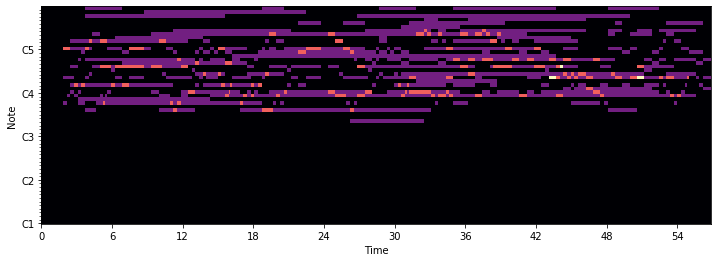

In [15]:
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)

In [16]:
IPython.display.Audio(pm.synthesize(fs=16000),rate=16000)

## HMM variant 1: Two-layered HMM

### Fitting and Evaluation

In [17]:
def lhmm(num_states,xNotes):
    model = hmm.MultinomialHMM(n_components=m[t])
    observ_data = xNotes.reshape(len(xNotes),1)
    model.fit(observ_data)
    results = model.predict(observ_data)
    Tmat = model.transmat_
    phi = model.emissionprob_
    pi = model.startprob_
    
    zStar = Viterbi(n, m[t], k, np.log(pi), np.log(Tmat), np.log(phi), xNotes)
    zStar = np.array(zStar).astype(int)
    
    return zStar,phi

In [18]:
from BaumWelch import *

# NUMBER OF HIDDEN STATES
m = [10,20]
names=['lhmm10','lhmm20']


for t in range(len(m)):
    zStar1,phi1 = lhmm(m[t],xNotes)
    zStar2,phi2 = lhmm(m[t],zStar1)
    
    z = [zStar1, zStar2]
    
    # Evaluation 
    it =10
    print(names[t])
    m_list=[]
    for i in range(it):
        output = np.zeros(shape = (2,n), dtype = int)
        xstates = range(0, k)
        zstates = range(0, m[t])
        for j in range(0,n):
            output[1, j] = np.random.choice(zstates, size = 1, p = phi2[zStar2[j], :])
            #print(phi1_saved.shape)
            output[0, j] = np.random.choice(xstates, size = 1, p = phi1[output[1, j], :])
            
        temp_notes = decode(output[0,:], possibleNotes).astype(int)
        newNotes = temp_notes
        newNotes = newNotes[:len(notes_template)]
        newVelocities = find_vel(newNotes, velocity,False)
        metrics = calc_metrics(time, notes_template, newNotes, newVelocities, measures, min_note, num)
        m_list.append(metrics)
        
        # Output music into csv 
        output_filename = dir_path+fname+'_'+names[t]+'_'+str(i)+'.csv'
        print(output_filename)
        output_music_csv(output_filename,time,newNotes,newVelocities)
        
    Metrics[names[t]]=m_list
    


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


lhmm10
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm10_0.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm10_1.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm10_2.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm10_3.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm10_4.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm10_5.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm10_6.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm10_7.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm10_8.csv
/Users/yanqi

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


lhmm20
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm20_0.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm20_1.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm20_2.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm20_3.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm20_4.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm20_5.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm20_6.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm20_7.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_lhmm20_8.csv
/Users/yanqi

## HMM variant 2: AR+Layered HMM

In [19]:
def Viterbi2(n, m, k, pi, Tmat,phi, x, psi):
    f = np.zeros(shape = (n,m))
    alpha = np.zeros(shape = (n,m))
    zStar = np.zeros(n)
    
    for t in range(0, n):
        for i in range(0,m):
            if t == 0:
                f[0, i] = pi[i] + phi[i, x[0]]
            else:
                #print(f[t-1, :].shape,Tmat[:, i].shape,psi[i, x[t], x[t-1]].shape)
                u = np.asarray(f[t-1, :]) + np.asarray(Tmat[:, i]) + psi[i, x[t], x[t-1]]
                
                f[t,i] = np.max(u)
                alpha[t,i] = np.argmax(u)
    zStar[n-1] = np.argmax(np.asarray(f[n-1, :]))
    for i in range(n-2, -1, -1):
        zStar[i] = alpha[i+1, int(zStar[i+1])]
    return zStar

In [20]:
def hmmARHMM(n, pi, phi, Tmat, psi, code):
    m = Tmat.shape[0]
    k = phi.shape[1]
    zstates = np.arange(0, m)
    xstates = np.arange(0, k)
    z = np.zeros(n, dtype = int)
    x = np.zeros(n, dtype = int)
    z[0] = np.random.choice(zstates, size = 1, p = pi)
    x[0] = np.random.choice(xstates, size = 1, p = phi[z[0], :])
    
    for j in range(1, n):
        z[j] = np.random.choice(zstates, size = 1, p = Tmat[z[j-1], :])
    for i in range(0, n):
        x[i] = np.random.choice(xstates, size = 1, p = psi[z[i], :, x[i-1]])
    output = decode(x, code)
    return(output, z)

### Fitting and Evaluation

In [29]:
m = [5]
names = ['arhmm10']

tol =0.01
#xNotes1=xNotes[:5000]
for t in range(len(m)):
    
    model1 = hmm.MultinomialHMM(n_components=m[t])
    observ_data = xNotes.reshape(len(xNotes),1)
    model1.fit(observ_data)
    results = model1.predict(observ_data)
    Tmat1 = model1.transmat_
    phi1 = model1.emissionprob_
    pi1 = model1.startprob_
    
#    it1, p1, pi1, phi1, Tmat1 = first_order(n, m[t], k, xNotes, tol)
    it2, p2, psi = first_orderARHMM(n, m[t], k, np.log(pi1), np.log(Tmat1), np.log(phi1), xNotes,  tol)
    newNotes,z  = hmmARHMM(n, pi1, phi1, Tmat1, psi, possibleNotes)
 
    zStar1 = Viterbi2(n, m[t], m[t], np.log(pi1), np.log(Tmat1), np.log(phi1), zStar1,np.log(psi))
    zStar1 = np.array(zStar1).astype(int)
    
    #     model2 = hmm.MultinomialHMM(n_components=m[t])
    #     observ_data = zStar1.reshape(len(zStar1),1)
    #     model2.fit(observ_data)
    #     results = model2.predict(observ_data)
    #     Tmat2 = model2.transmat_
    #     phi2 = model2.emissionprob_
    #     pi2 = model2.startprob_

    it2, p2, pi2, phi2, Tmat2 = first_order(n, m[t], m[t], zStar1, tol)
    zStar2 = Viterbi(n, m[t], m[t], np.log(pi2), np.log(Tmat2), np.log(phi2), zStar1)
    zStar2 = np.array(zStar2).astype(int)
    
   
    # Evaluation 
    it =10
    #print(names[t])
    m_list=[]
    for i in range(it):
        output = np.zeros(shape = (2,n), dtype = int)
        xstates = range(0, k)
        zstates = range(0, m[t])

        for j in range(0,n):
            #print(phi2.shape)
            output[1, j] = np.random.choice(zstates, size = 1, p = phi2[zStar2[j], :])
            
            output[0, j] = np.random.choice(xstates, size = 1, p = phi1[output[1, j], :])
        temp_notes = decode(output[0,:], possibleNotes).astype(int)
        newNotes = temp_notes
        newNotes = newNotes[:len(notes_template)]
        newVelocities = find_vel(newNotes, velocity,False)
        metrics = calc_metrics(time, notes_template, newNotes, newVelocities, measures, min_note, num)
        m_list.append(metrics)
        
        # Output music into csv 
        output_filename = dir_path+fname+'_'+names[t]+'_'+str(i)+'.csv'
        print(output_filename)
        output_music_csv(output_filename,time,newNotes,newVelocities)

        
    Metrics[names[t]]= m_list

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


1
2
3
4
5
6


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_arhmm10_0.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_arhmm10_1.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_arhmm10_2.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_arhmm10_3.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_arhmm10_4.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_arhmm10_5.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_arhmm10_6.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_arhmm10_7.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/13Alleinzudir_arhmm10_8.csv
/Users/yan

## Music Evaluation bach/dmm/lstm 

In [30]:
class pre_process2(object):
    def __init__(self, input_filename, min_note):
        self.input_filename = input_filename
        self.min_note = min_note
      
    
    def read_process(self):
        with open(self.input_filename,encoding = "ISO-8859-1") as fd:
            reader=csv.reader(fd)
            rows= [row for idx, row in enumerate(reader)]
        song = pd.DataFrame(rows)
        r,c = np.where(song == ' Header')
        quarter_note = song.iloc[r,5].values.astype(int)[0]
        r, c = np.where(song == ' Time_signature')
        num = 4
        denom = 4
        try:
            r, c = np.where(song == ' Key_signature')
            key = song.iloc[r,3].values.astype(int)[0]
        except:
            key = None
        
        song_model = song.loc[song.iloc[:,0] == np.max(song.iloc[:,0])]
        song_model = song_model[song_model.iloc[:, 2].isin([' Note_on_c', ' Note_off_c'])]
        time = np.array(song_model.iloc[:,1]).astype(int)
        notes = np.array(song_model.iloc[:,4]).astype(int)
        velocity = np.array(song_model.iloc[:,5]).astype(int)
        measures = np.round(np.max(time)/quarter_note)/num
        min_note = quarter_note
        actual = np.arange(0, min_note*measures*num, min_note).astype(int) 
        time = np.array([find_nearest(actual, time[i]) for i in range(len(time))]).astype(int)
        return(quarter_note, num, denom, key, measures, time, notes, velocity, song, song_model.index)

### DMM

In [31]:
import glob

min_note = 1024
m_list=[]
for filepath in glob.iglob('/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/dmm_music/*.csv'):
    print(filepath)
#     dir_path = '/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/'
#     filepath = os.path.join(dir_path,fname+'.csv')
    music = pre_process2(filepath,min_note)

    quarter_note, num, denom, key, measures, time, \
            notes_template, velocity, song, ind = music.read_process()
    possibleVelocities =  np.unique(velocity)
    metrics = calc_metrics(time, notes_template, notes_template, velocity, measures, min_note, num)
    m_list.append(metrics)

Metrics['dmm'] = m_list

/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/dmm_music/jsb-12.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/dmm_music/jsb-11.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/dmm_music/jsb-10.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/dmm_music/jsb-14.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/dmm_music/jsb-15.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/dmm_music/jsb-16.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/dmm_music/jsb-35.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/dmm_music/jsb-46.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/dmm_music/jsb-0.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/

### Bach

In [32]:
min_note = 1024
m_list=[]
for filepath in glob.iglob('/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/10_bach/*.csv'):
    print(filepath)
#     dir_path = '/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/'
#     filepath = os.path.join(dir_path,fname+'.csv')
    music = pre_process(filepath,min_note)

    quarter_note, num, denom, key, measures, time, \
            notes_template, velocity, song, ind = music.read_process()
    possibleVelocities =  np.unique(velocity)
    metrics = calc_metrics(time, notes_template, notes_template, velocity, measures, min_note, num)
    m_list.append(metrics)

Metrics['bach'] = m_list

/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/10_bach/000707b_.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/10_bach/000507b_.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/10_bach/000606b_.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/10_bach/000907b_.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/10_bach/000306b_.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/10_bach/000206b_.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/10_bach/000806b_.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/10_bach/000408b_.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/10_bach/001207b_.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/10_bach/001106b_.csv


### LSTM

In [33]:
Metrics={}
filepath = '/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/DS3001-timeseries/results/lstm.csv'
music = pre_process2(filepath,min_note)

quarter_note, num, denom, key, measures, time, \
        notes_template, velocity, song, ind = music.read_process()
possibleVelocities =  np.unique(velocity)
metrics = calc_metrics(time, notes_template[:206], notes_template[:206], velocity, measures, min_note, num)

Metrics['lstm']=[metrics]


### Output evaluation results 

In [141]:
m = Metrics.copy()
lis = m.keys()

In [144]:
m = Metrics.copy()
final={}
for i in lis:
    a1=[]
    for j in m[i]:
        b=[]
        for n in j:
            b.append(n.tolist())
                
        a1.append(b)
    final[i]=a1

In [145]:
import json
with open('result.json', 'w') as fp:
    json.dump(final, fp)

In [120]:
final.keys()

dict_keys(['hmm10', 'hmm20', 'hmm30', 'lhmm10', 'lhmm20', 'dmm', 'bach', 'lstm', 'arhmm5'])